In [100]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [20]:
%run dataloader.ipynb

train size:  7614
dev size:  980
test size:  994


In [132]:
batch_size=500
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [67]:
gpu_id = 'cuda:4'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [23]:
'''
x_p.shape=batch_size*maximum number of words in sentence * 752
x_c.shape = batch_size * maximum context length in #sentences * maximum sentence length in #words * 752
here 752 = word embedding (300) + covarep (81) + openface(371)  
'''

device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
for batch_idx, batch in enumerate(dev_dataloader, 0): 
    x_p,x_c,y,hid=map(lambda x: x.to(device), batch)
    print("*********")
    print('id: ', hid)
    print("punchline shape: ",x_p.shape)
    print(x_p[:, :, 300:].shape)
    print("context shape: ",x_c.shape)
    print("humor labels: ",y.shape)
    if batch_idx==0:
        break

/tmp/ipykernel_3249000/1429692890.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3249000/1429692890.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3249000/1429692890.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you m

*********
id:  tensor([ 5950, 14814,  8586,  1534,  3826, 14649,  3413,  4812, 15107, 13418,
         3547,  8562, 13049,  1553,  6567,  2764,  9576,  4210, 14856, 11732,
         2058,  9526,  7683, 13988,  2803,  3414, 12800, 15398,   109,  3044,
         1936,  3371,   804,  9571,  9520,  5991,   287,  4153,  3379, 10446,
        12381, 11916,   813,  3764,  3094,  4589, 13028,  1539, 10561, 10936,
         5271,  9703,  3033,  7568, 14927,  9529,  7040, 12032,  7978,  1305,
        14178,  4113,  1931, 11730,   358,  2177,  8951,  4872,   580,  1311,
         3530,  7557, 13275,  3824,  7541, 13478, 14935, 13473,    27,  4564,
         6558, 12379, 15103,  4866,  2176,  2799,  5918, 11745,   819,  8154,
        14655, 14391,  9691,  9646, 13416, 12050,  4114,  9334, 10953,  9577],
       device='cuda:4')
punchline shape:  torch.Size([100, 20, 752])
torch.Size([100, 20, 452])
context shape:  torch.Size([100, 5, 20, 752])
humor labels:  torch.Size([100, 1])


In [68]:
# random
class Random():

    def __init__(self) -> None:
        pass
    
    def predict(self, x):
        return torch.tensor([[random.randint(0,1)] for i in range(x.shape[0])], dtype=torch.int64, device=device)

In [79]:
random_baseline = Random()
matches = 0
total = 0
for batch_idx, batch in enumerate(test_dataloader, 0): 
    x_p,x_c,y,hid=map(lambda x: x.to(device), batch)
    predictions = random_baseline.predict(x_p)
    matches += (y == predictions).sum()
    total += len(y)
acc = matches / total
print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_3249000/1429692890.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3249000/1429692890.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3249000/1429692890.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you m

test accuracy: 50.30%


In [120]:
# single layer linear
class SingleLayer(torch.nn.Module):

    def __init__(self) -> None:
        super().__init__()
        self.linear = torch.nn.Linear(20*300, 1, dtype=torch.float64)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.linear(x)


In [122]:
singlelayer_baseline = SingleLayer()
singlelayer_baseline.to(device)

optimiser = torch.optim.Adam(singlelayer_baseline.parameters(), lr=0.001)
epochs = 10

print('step', 'error')
dev_accs = []
errors = []
for epoch in range(1, epochs+1):
    for batch_idx, batch in enumerate(train_dataloader, 0): 
        x_p,x_c,y,hid=map(lambda x: x.to(device), batch)

        optimiser.zero_grad()
        output = singlelayer_baseline(x_p[:, :, :300])
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0): 
            x_p,x_c,y,hid=map(lambda x: x.to(device), batch)
            outputs = torch.sigmoid(singlelayer_baseline(x_p[:, :, :300]))
            predictions = (outputs > 0.5)*1
            matches += (y == predictions).sum()
            total += len(y)
        acc = matches / total
        dev_accs.append(float(acc))
        print('dev accuracy: {:.2%}'.format(float(acc)))

plt.plot(range(1, epochs+1), dev_accs, 'b')
plt.title('dev set accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(range(1, epochs+1), errors, 'r')
plt.title('train error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.show()

step error


/tmp/ipykernel_3249000/1429692890.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3249000/1429692890.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3249000/1429692890.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you m

1 0.6736777584363978
dev accuracy: 59.18%
2 0.6816402010822104
dev accuracy: 59.80%
3 0.4701349381311047
dev accuracy: 58.78%


KeyboardInterrupt: 

In [86]:
with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid=map(lambda x: x.to(device), batch)
        outputs = torch.sigmoid(singlelayer_baseline(x_p[:, :, :300]))
        predictions = (outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
    acc = matches / total
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_3249000/1429692890.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3249000/1429692890.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3249000/1429692890.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you m

test accuracy: 61.37%


In [124]:
# multi layer linear
class MultiLayer(torch.nn.Module):

    def __init__(self, hidden_layer_size, leaky_relu_factor=0.1, dropout_rate=0.1) -> None:
        super().__init__()
        self.linear1 = torch.nn.Linear(20*300, hidden_layer_size, dtype=torch.float64)
        self.linear2 = torch.nn.Linear(hidden_layer_size, 1, dtype=torch.float64)
        self.leaky_relu_factor = leaky_relu_factor
        self.dropout_rate = dropout_rate

    def forward(self, x, being_trained=False):
        x = torch.flatten(x, start_dim=1)
        hidden = torch.nn.functional.leaky_relu(self.linear1(x), self.leaky_relu_factor)
        if being_trained:
            hidden = torch.nn.functional.dropout(hidden, self.dropout_rate)
        return self.linear2(hidden)


step error


/tmp/ipykernel_3249000/1429692890.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3249000/1429692890.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3249000/1429692890.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you m

1 0.6524606116229762
dev accuracy: 59.18%
2 0.6319076896187367
dev accuracy: 58.47%
3 0.4613497087887326
dev accuracy: 58.16%
4 0.434121144571868
dev accuracy: 57.14%
5 0.28353244390856075
dev accuracy: 55.20%
6 0.20779196503469147
dev accuracy: 56.73%
7 0.1177131374855405
dev accuracy: 56.43%
8 0.04334872334240528
dev accuracy: 56.63%
9 0.054028262170889414
dev accuracy: 55.92%
10 0.05866650740742313
dev accuracy: 57.04%
11 0.02040247067566325
dev accuracy: 56.02%
12 0.016593806857853485
dev accuracy: 56.53%
13 0.011397164733142019
dev accuracy: 56.22%
14 0.017535940323737315
dev accuracy: 55.41%
15 0.01423454791357218
dev accuracy: 57.04%
16 0.01337305051816671
dev accuracy: 56.53%
17 0.005401984375418925
dev accuracy: 57.35%
18 0.022237186976154476
dev accuracy: 56.02%
19 0.04938493191951367
dev accuracy: 57.04%
20 0.005497091430139751
dev accuracy: 57.45%


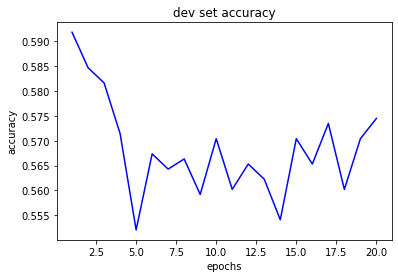

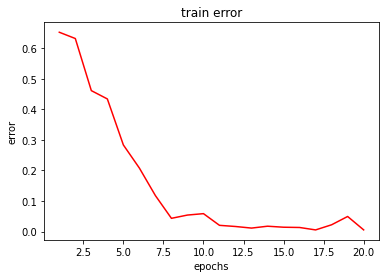

In [133]:
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
multilayer_baseline = MultiLayer(hidden_layer_size=2048)
multilayer_baseline.to(device)

optimiser = torch.optim.Adam(multilayer_baseline.parameters(), lr=0.001)
epochs = 20

print('step', 'error')
dev_accs = []
errors = []
for epoch in range(1, epochs+1):
    for batch_idx, batch in enumerate(train_dataloader, 0): 
        x_p,x_c,y,hid=map(lambda x: x.to(device), batch)

        optimiser.zero_grad()
        output = multilayer_baseline(x_p[:, :, :300], True)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0): 
            x_p,x_c,y,hid=map(lambda x: x.to(device), batch)
            outputs = torch.sigmoid(multilayer_baseline(x_p[:, :, :300]))
            predictions = (outputs > 0.5)*1
            matches += (y == predictions).sum()
            total += len(y)
        acc = matches / total
        dev_accs.append(float(acc))
        print('dev accuracy: {:.2%}'.format(float(acc)))

plt.plot(range(1, epochs+1), dev_accs, 'b')
plt.title('dev set accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(range(1, epochs+1), errors, 'r')
plt.title('train error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.show()

In [134]:
with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid=map(lambda x: x.to(device), batch)
        outputs = torch.sigmoid(multilayer_baseline(x_p[:, :, :300]))
        predictions = (outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
    acc = matches / total
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_3249000/1429692890.py:99: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3249000/1429692890.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3249000/1429692890.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you m

test accuracy: 57.85%
